In [1]:
#Importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import math
import random 

In [2]:
#Declaring the variables required
dead_cells={}
resurrected_cells={}
resurrecting_pos=[]
random_dead_cells=[]

In [3]:
#Function to set the initial state of the grid

def generate_grid(N):
    size = 2 * N + 1
    grid = []

    for row in range(size):
        row_size = size - abs(N - row)
        inner_row = [None] * row_size
        grid.append(inner_row)

    alive_count = 0  

    for r in range(size):
        for q in range(size -abs(N - r)):
            if alive_count < 10:
                alive = random.choice([True, False])
                if alive:
                    grid[r][q] = ((q +max(0, N-r), r), 1)
                    alive_count += 1
                else:
                    grid[r][q]= ((q + max(0, N-r), r), 0)
            else:
                grid[r][q] =((q + max(0, N-r), r), 0)
    return grid


In [4]:
#Converting Axial coordinates to Screen coordinates
def axial_to_screen(q, r, hex_size):
    screen_x = hex_size * math.sqrt(3) * (q + r/2)
    screen_y = hex_size * 3/2 * r
    return screen_x, screen_y

In [5]:
#Function to generate grid based on screen coordinates
def screen_coordinate_grid(N, grid,hex_size):
    screen_coord=[]
    size=2*N+1

    for row in range(size):
        row_size = size - abs(N - row)
        inner_row = [None] * row_size
        screen_coord.append(inner_row)

    for r in range(size):
        for q in range(size - abs(N-r)):
            screen_coord[r][q]=(axial_to_screen(grid[r][q][0][0], grid[r][q][0][1],10),grid[r][q][1])
            
    return screen_coord

In [6]:
#Functions to calculate corners of the hexagon 
def hex_corner(center, size, i):
    degree = (60 * i) + 30
    radians = math.pi / 180 * degree
    return (center[0] + size * math.cos(radians),
            center[1] + size * math.sin(radians))

def calculate_hexagon_vertices(center, size):
    vertices = []
    for i in range(6):
        vertex = hex_corner(center, size, i)
        vertices.append(vertex)
    return vertices

In [7]:
def plot_hexagons(screen_centers, hex_size):
    fig, ax = plt.subplots()
    i = 0
    background_color = "black"
    dead_cell="black"
    alive_cell=(57/255, 210/255, 20/255)
    for rows in screen_centers:
        for center in rows:
            vertices = calculate_hexagon_vertices(center[0], hex_size)
            if center[1] == 0:
                color = dead_cell
            elif center[1] == 1:
                color = alive_cell
            plt.gca().add_patch(Polygon(vertices, closed=True, fill=True, facecolor=color, edgecolor=(57/255, 210/255, 20/255)))
            i += 1
    plt.axis('equal')
    fig.patch.set_facecolor(background_color)
    plt.axis('off')
    plt.show()

In [8]:
#Function to implement rule number 7 (random dead cell resurrection)
def update_random_dead_cells(grid):
    global random_dead_cells
    random_dead_cells.clear()
    for row in grid:
        for cell in row:
            if not is_alive(cell[0]):
                random_dead_cells.append(cell[0])

def random_dead_cell_selection():
    global random_dead_cells
    return random.choice(random_dead_cells)

In [9]:
#Function to calculate the neighbours
def alive_neighbours(cell,grid):
    directions=[(1, 0), (1, -1), (0, -1), (-1, 0), (-1, 1), (0, 1)]
    count=0
    for direction in directions:
        coord=tuple(x + y for x, y in zip(cell, direction))
        for row in grid:
            for center in row:
                if center[0] == coord:
                    if center[1]==1:
                        count=count+1
                        
    return count


In [10]:
def is_alive(cell):
    return cell[1]==1


In [11]:
def is_born(cell,grid):
    neighbours=alive_neighbours(cell[0],grid)
    return (not is_alive(cell)) and neighbours==3

In [12]:
def next_gen_grid(N, parent_grid,count):
    size=2*N+1
    new_grid = []
    global resurrecting_pos
    pos=None
    if (count%4==0):
        update_random_dead_cells(parent_grid)
        pos=random_dead_cell_selection()
    
    for row in range(size):
        row_size = size - abs(N - row)
        inner_row = [None] * row_size
        new_grid.append(inner_row)
        
    for r in range(size):
        for q in range(size - abs(N-r)):
            cell=parent_grid[r][q]
            if ((cell[0] in resurrecting_pos) or survives(cell, parent_grid) or is_born(cell, parent_grid) or (pos is not None and cell[0]==pos)):
                state=1
            else:
                state=0
            new_grid[r][q]=((q+(max(0,N-r)),r),state)
            
    return new_grid

In [13]:
def survives(cell,grid):
    global dead_cells
    global resurrected_cells
    global resurrecting_pos
    neighbours=alive_neighbours(cell[0],grid)
    if is_alive(cell) and neighbours < 2:
        if ((cell[0] not in dead_cells) and (( cell[0] in resurrected_cells and resurrected_cells[cell[0]] != "UP") or cell[0] not in resurrected_cells)):
            dead_cells[cell[0]]=(0,"UP")  #updates teh dead_cells dictionary after checking the necessary condition
    elif is_alive(cell) and neighbours > 3:
        if ((cell[0] not in dead_cells) and (( cell[0] in resurrected_cells and resurrected_cells[cell[0]] != "OP") or cell[0] not in resurrected_cells)):
            dead_cells[cell[0]]=(0,"OP")

    state=is_alive(cell) and neighbours in [2,3]

    if is_alive(cell) and neighbours < 2:
        if ( ( cell[0] in resurrected_cells and Generation.resurrected_cells[cell[0]] == "UP")):
            state=1
    elif is_alive(cell) and neighbours > 3:
        if ( ( cell[0] in resurrected_cells and resurrected_cells[cell[0]] == "OP")):
            state=1
    return state

In [14]:
#Updates teh dead cells dictioanry after every generation
def update_dying_cells():
    updated_dead_cells={}
    global dead_cells
    global resurrected_cells
    global resurrecting_pos
    resurrected_cells.clear()
    for cell, value in dead_cells.items():
        if(value[0]+1!=6): 
            updated_value = (value[0] + 1, value[1])
            updated_dead_cells[cell] = updated_value
        if(value[0]+1==6):
            if cell not in resurrected_cells:
                resurrected_cells[cell]=value
            else:
                del resurrected_cells[cell]
                resurrected_cells[cell]=value
            resurrecting_pos.append(cell)
    dead_cells=updated_dead_cells

Parent Generation


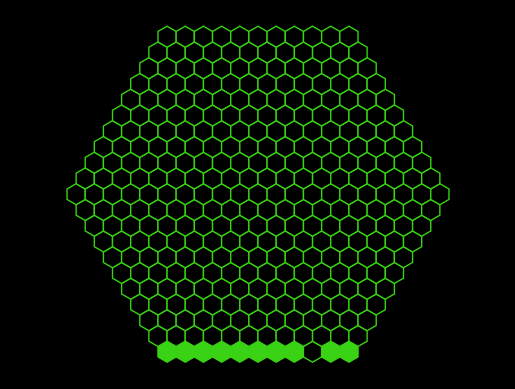

Generation: 1


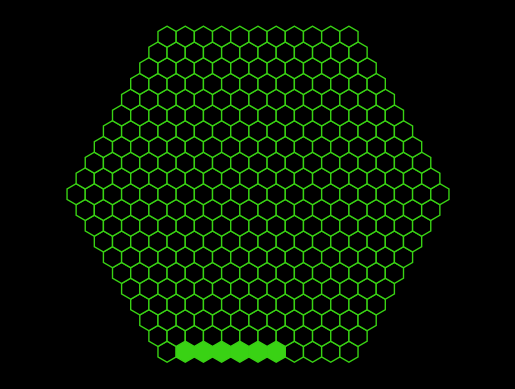

Generation: 2


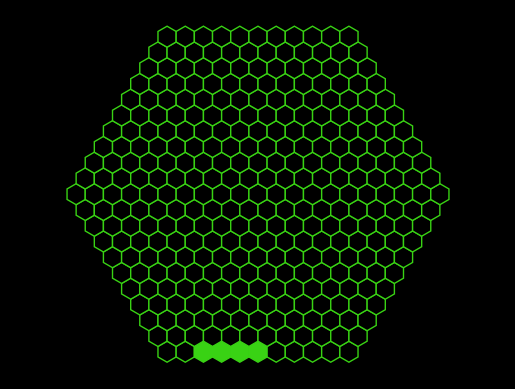

Generation: 3


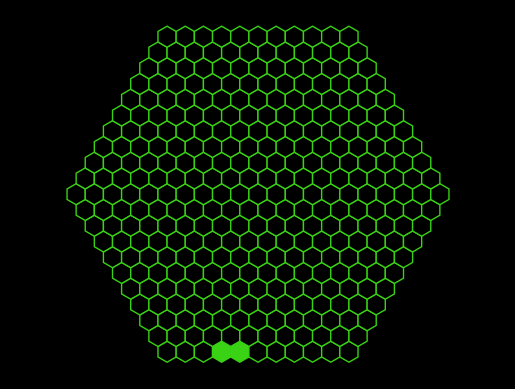

Generation: 4


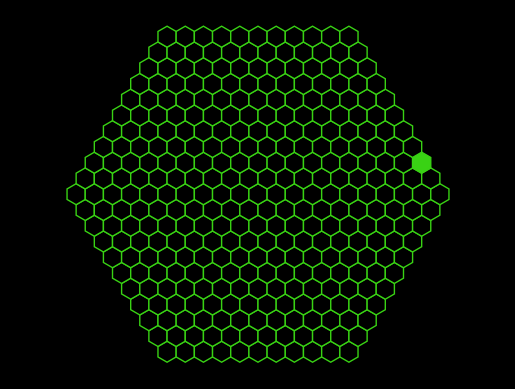

Generation: 5


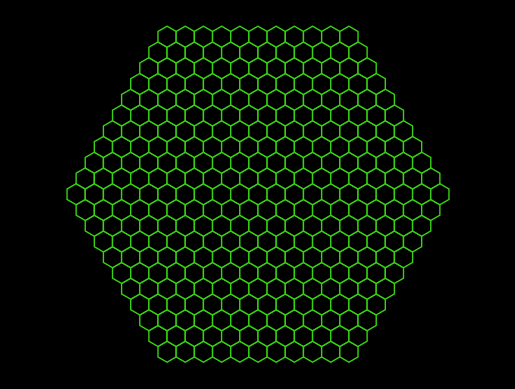

Generation: 6


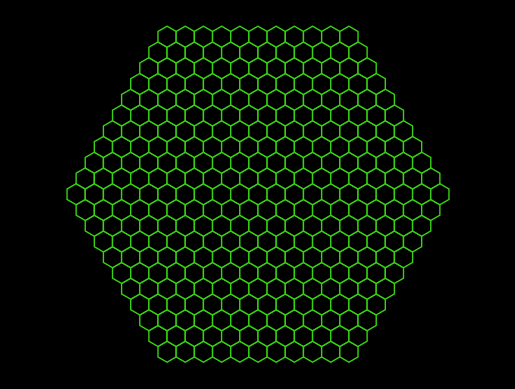

Generation: 7


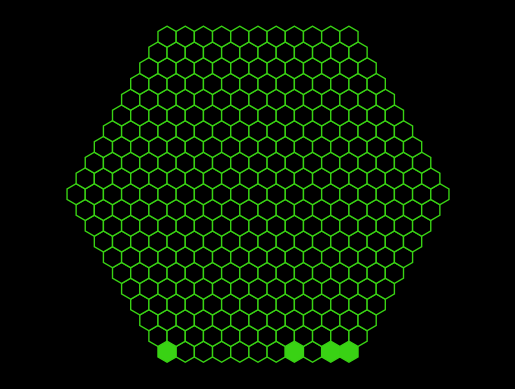

Generation: 8


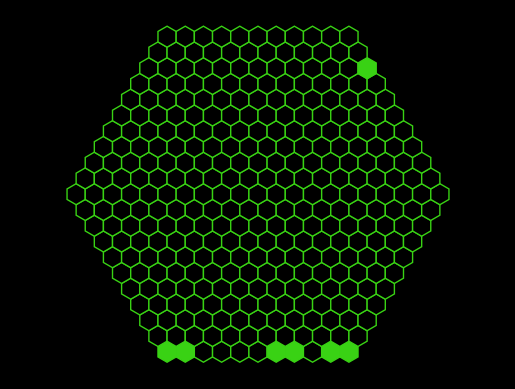

Generation: 9


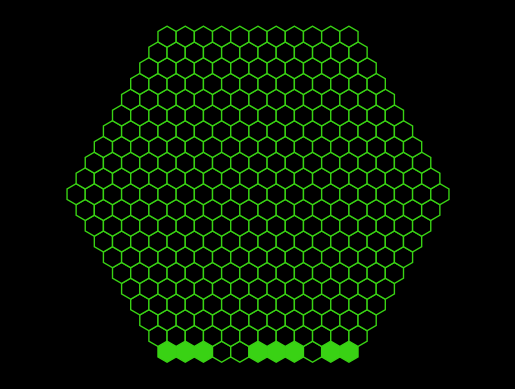

Generation: 10


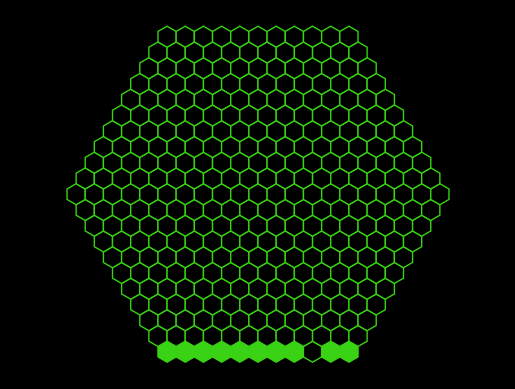

Generation: 11


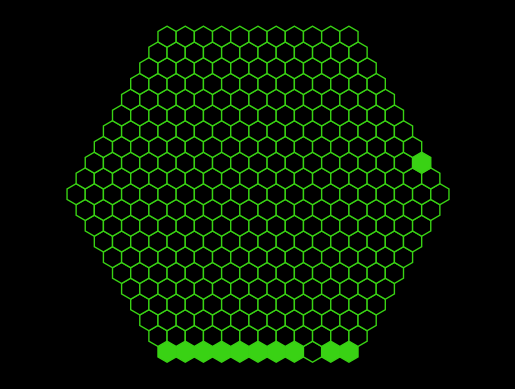

Generation: 12


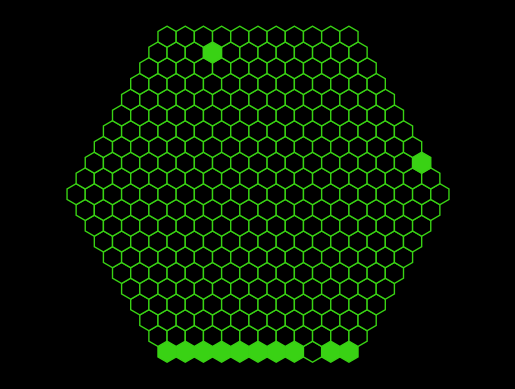

In [ ]:
cell_nos=10
hex_size=5
generations=20
parent_grid=generate_grid(cell_nos)
screen_coord=screen_coordinate_grid(cell_nos, parent_grid,hex_size)
print("Parent Generation")
plot_hexagons(screen_coord,10)
for i in range(1,generations):
    update_dying_cells()
    new_gen_grid=next_gen_grid(cell_nos,parent_grid,i)
    screen_coord_new_gen=screen_coordinate_grid(cell_nos, new_gen_grid,hex_size)
    print("Generation:", i)
    plot_hexagons(screen_coord_new_gen,10)
    parent_grid=new_gen_grid
    
print("All Frames Generated!!")

